In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("database.csv")
df.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')

In [3]:
df = df[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
df.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       23412 non-null  object 
 1   Time       23412 non-null  object 
 2   Latitude   23412 non-null  float64
 3   Longitude  23412 non-null  float64
 4   Depth      23412 non-null  float64
 5   Magnitude  23412 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.1+ MB


In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')


df['Year'] = df['Date'].dt.year
df_filtered = df[df['Year'] >= 1971]
df_filtered.drop("Year",axis=1,inplace=True)
df_filtered.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
1801,1971-01-01,07:58:03,-4.190,141.183,35.0,6.0
1802,1971-01-03,17:35:41,-55.918,-2.668,15.0,7.1
1803,1971-01-04,03:59:12,-29.644,-111.835,10.0,5.7
1804,1971-01-04,21:08:55,34.530,137.151,42.1,5.8
1805,1971-01-06,06:04:22,36.374,141.231,35.0,5.6


In [6]:
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'], format='%Y-%m-%d')

df_filtered['Date'] = df_filtered['Date'].dt.strftime('%m/%d/%Y')

df_filtered.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
1801,01/01/1971,07:58:03,-4.190,141.183,35.0,6.0
1802,01/03/1971,17:35:41,-55.918,-2.668,15.0,7.1
1803,01/04/1971,03:59:12,-29.644,-111.835,10.0,5.7
1804,01/04/1971,21:08:55,34.530,137.151,42.1,5.8
1805,01/06/1971,06:04:22,36.374,141.231,35.0,5.6


In [7]:
import datetime
import time

timestamp = []
for d, t in zip(df_filtered['Date'], df_filtered['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        timestamp.append('ValueError')
timeStamp = pd.Series(timestamp)
df_filtered['Timestamp'] = timeStamp.values
final_data = df_filtered.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()

,Latitude,Longitude,Depth,Magnitude,Timestamp
1801,-4.190,141.183,35.0,6.0,31553883.0
1802,-55.918,-2.668,15.0,7.1,31761341.0
1803,-29.644,-111.835,10.0,5.7,31798752.0
1804,34.530,137.151,42.1,5.8,31860535.0
1805,36.374,141.231,35.0,5.6,31979062.0


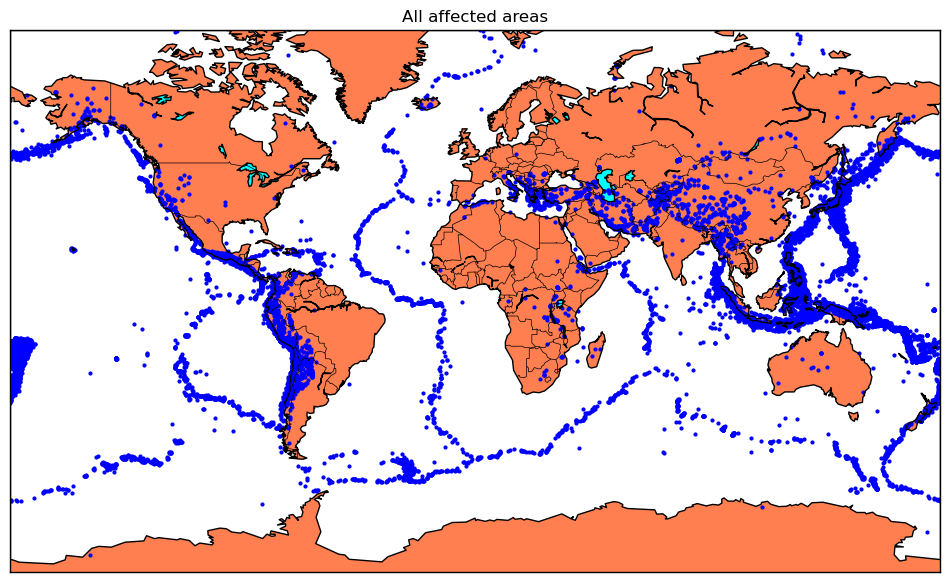

In [8]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = df_filtered["Longitude"].tolist()
latitudes = df_filtered["Latitude"].tolist()

x,y = m(longitudes,latitudes)

fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

X = final_data[['Timestamp', 'Latitude', 'Longitude']]
y = final_data[['Magnitude', 'Depth']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(17286, 3) (4322, 3) (17286, 2) (4322, 2)


In [10]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [11]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

neurons = [16]
batch_size = [10]
epochs = [10]
activation = ['sigmoid', 'relu']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

In [12]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.600000 using {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.200000 (0.400000) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.400000 (0.489898) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}
0.600000 (0.489898) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.400000 (0.489898) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}


In [13]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Epoch 1/20
1729/1729 [==============================] - 6s 3ms/step - loss: 0.5043 - accuracy: 0.9794 - val_loss: 0.5036 - val_accuracy: 0.9817
Epoch 2/20
1729/1729 [==============================] - 4s 3ms/step - loss: 0.5043 - accuracy: 0.9794 - val_loss: 0.5036 - val_accuracy: 0.9817
Epoch 3/20
1729/1729 [==============================] - 4s 2ms/step - loss: 0.5043 - accuracy: 0.9794 - val_loss: 0.5036 - val_accuracy: 0.9817
Epoch 4/20
1729/1729 [==============================] - 4s 2ms/step - loss: 0.5043 - accuracy: 0.9794 - val_loss: 0.5036 - val_accuracy: 0.9817
Epoch 5/20
1729/1729 [==============================] - 5s 3ms/step - loss: 0.5043 - accuracy: 0.9794 - val_loss: 0.5036 - val_accuracy: 0.9817
Epoch 6/20
1729/1729 [==============================] - 5s 3ms/step - loss: 0.5043 - accuracy: 0.9794 - val_loss: 0.5036 - val_accuracy: 0.9817
Epoch 7/20
1729/1729 [==============================] - 4s 2ms/step - loss: 0.5043 - accuracy: 0.9794 - val_loss: 0.5036 - val_accuracy: